## Data preparation

In [1]:
from scripts.get_data import get_processed_data
from scripts.models import VotingClassifier

In [2]:
# logistic regression
from sklearn.linear_model import LogisticRegression 
# elastic net 
from sklearn.linear_model import ElasticNet
# svm classifier
from sklearn.svm import SVC
# lda 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np

In [3]:
from sklearn.feature_selection import f_regression, SelectKBest

data, labels = get_processed_data(corr_thresh=0.9, minmax_scale=True, var_thresh=0.01, k_to_select='all')

In [9]:
from sklearn.model_selection import train_test_split

X_training_pre, X_test_pre, Y_training, Y_test = train_test_split(data, labels, test_size=0.1, random_state=932)
X_train_pre, X_val_pre, Y_train, Y_val = train_test_split(X_training_pre, Y_training, test_size=1/9)
X_train_pre.shape, Y_train.shape, X_val_pre.shape, Y_val.shape, X_test_pre.shape, Y_test.shape

((105, 20074), (105, 1), (14, 20074), (14, 1), (14, 20074), (14, 1))

In [10]:
import pandas as pd

feat_sel = SelectKBest(score_func=f_regression, k=1000)

X_train_sel = feat_sel.fit_transform(X_train_pre, Y_train)
X_val_sel = feat_sel.transform(X_val_pre)
X_test_sel = feat_sel.transform(X_test_pre)
cols_sel = feat_sel.get_feature_names_out(X_train_pre.columns)

X_train = pd.DataFrame(X_train_sel, columns=cols_sel, index=X_train_pre.index)
X_val = pd.DataFrame(X_val_sel, columns=cols_sel, index=X_val_pre.index)
X_test = pd.DataFrame(X_test_sel, columns=cols_sel, index=X_test_pre.index)

/home/sooraj/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
from timeit import default_timer as timer   

## Modeling

In [17]:
from sklearn.metrics import mean_absolute_error as mae, median_absolute_error as med, r2_score as r2
from warnings import catch_warnings, simplefilter
import matplotlib.pyplot as plt
from seaborn import regplot

### LDA ensemble

In [14]:
model_lda = VotingClassifier(
    bin_size=20,
    estimator=LDA(solver='eigen', shrinkage='auto')
)

with catch_warnings():
    simplefilter('ignore')
    model_lda.train(X_train, Y_train)
    preds_train_lda, preds_val_lda = model_lda.predict(X_train), model_lda.predict(X_val)
    mae_train_lda, mae_val_lda = mae(Y_train, preds_train_lda), mae(Y_val, preds_val_lda)
    med_train_lda, med_val_lda = med(Y_train, preds_train_lda), med(Y_val, preds_val_lda)
    r2_train_lda, r2_val_lda = r2(Y_train, preds_train_lda), r2(Y_val, preds_val_lda)

print(f'Training: MAE = {mae_train_lda}, MED = {med_train_lda}, R2 = {r2_train_lda}')
print(f'Validation: MAE = {mae_val_lda}, MED = {med_val_lda}, R2 = {r2_val_lda}')

Training: MAE = 0.0, MED = 0.0, R2 = 1.0
Validation: MAE = 13.428571428571429, MED = 4.5, R2 = 0.31296373241526687


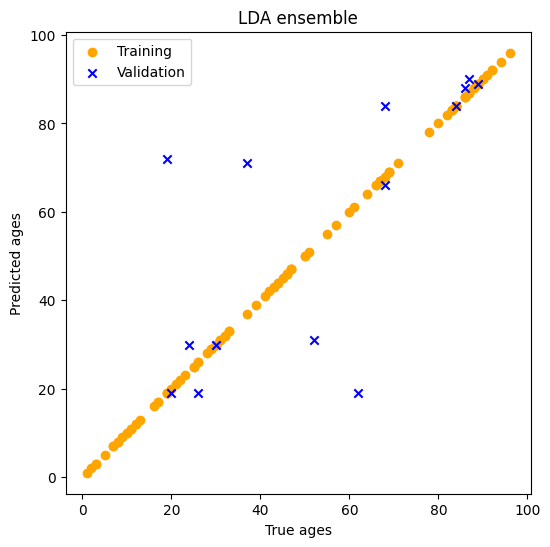

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(Y_train, preds_train_lda, c='orange', marker='o', label='Training')
plt.scatter(Y_val, preds_val_lda, c='blue', marker='x', label='Validation')
plt.xlabel('True ages')
plt.ylabel('Predicted ages')
plt.title('LDA ensemble')
plt.legend()

### SVC ensemble

In [16]:
model_svc = VotingClassifier(
    bin_size=20,
    estimator=SVC(kernel='linear')
)

with catch_warnings():
    simplefilter('ignore')
    model_svc.train(X_train, Y_train)
    preds_train_svc, preds_val_svc = model_svc.predict(X_train), model_svc.predict(X_val)
    mae_train_svc, mae_val_svc = mae(Y_train, preds_train_svc), mae(Y_val, preds_val_svc)
    med_train_svc, med_val_svc = med(Y_train, preds_train_svc), med(Y_val, preds_val_svc)
    r2_train_svc, r2_val_svc = r2(Y_train, preds_train_svc), r2(Y_val, preds_val_svc)

print(f'Training: MAE = {mae_train_svc}, MED = {med_train_svc}, R2 = {r2_train_svc}')
print(f'Validation: MAE = {mae_val_svc}, MED = {med_val_svc}, R2 = {r2_val_svc}')

Training: MAE = 0.0, MED = 0.0, R2 = 1.0
Validation: MAE = 18.928571428571427, MED = 9.5, R2 = -0.12819789873568


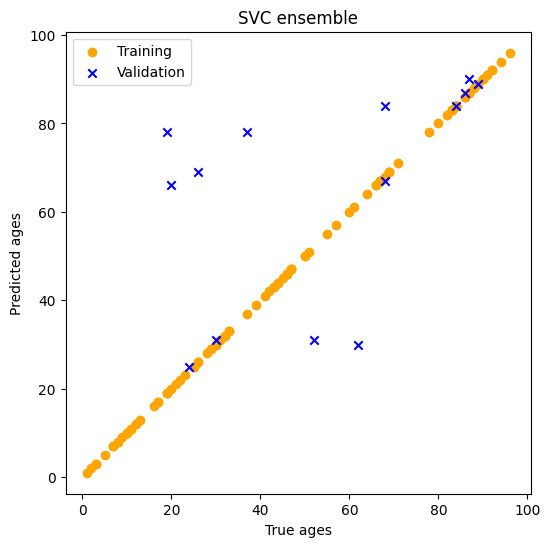

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(Y_train, preds_train_svc, c='orange', marker='o', label='Training')
plt.scatter(Y_val, preds_val_svc, c='blue', marker='x', label='Validation')
plt.xlabel('True ages')
plt.ylabel('Predicted ages')
plt.title('SVC ensemble')
plt.legend()

### Direct neural network

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.activations import relu
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError as MAELoss, MeanSquaredError
from keras.metrics import MeanAbsoluteError as MAEMetric

2023-05-13 22:41:43.892308: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-13 22:41:43.921361: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-13 22:41:44.047663: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-13 22:41:44.048373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 22:41:44.866708: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [141]:
model_dnn = Sequential([
    Dense(units=64, activation=relu, input_shape=(1000,)),
    Dense(units=128, activation=relu),
    Dense(units=1)
])
model_dnn.compile(optimizer=Adam(), loss=MAELoss(), metrics=[MAEMetric()])

model_dnn.fit(X_train, Y_train, batch_size=1, epochs=100, validation_data=(X_val, Y_val))
preds_train_dnn, preds_val_dnn = model_dnn.predict(X_train), model_dnn.predict(X_val)
mae_train_dnn, mae_val_dnn = mae(Y_train, preds_train_dnn), mae(Y_val, preds_val_dnn)
med_train_dnn, med_val_dnn = med(Y_train, preds_train_dnn), med(Y_val, preds_val_dnn)
r2_train_dnn, r2_val_dnn = r2(Y_train, preds_train_dnn), r2(Y_val, preds_val_dnn)

print(f'Training: MAE = {mae_train_dnn}, MED = {med_train_dnn}, R2 = {r2_train_dnn}')
print(f'Validation: MAE = {mae_val_dnn}, MED = {med_val_dnn}, R2 = {r2_val_svc}')

Epoch 1/100
105/105 [==============================] - 0s 2ms/step - loss: 30.4988 - mean_absolute_error: 30.4988 - val_loss: 23.4304 - val_mean_absolute_error: 23.4304
Epoch 2/100
105/105 [==============================] - 0s 899us/step - loss: 19.6542 - mean_absolute_error: 19.6542 - val_loss: 19.4474 - val_mean_absolute_error: 19.4474
Epoch 3/100
105/105 [==============================] - 0s 906us/step - loss: 17.1366 - mean_absolute_error: 17.1366 - val_loss: 23.0045 - val_mean_absolute_error: 23.0045
Epoch 4/100
105/105 [==============================] - 0s 888us/step - loss: 17.2040 - mean_absolute_error: 17.2040 - val_loss: 20.4351 - val_mean_absolute_error: 20.4351
Epoch 5/100
105/105 [==============================] - 0s 1ms/step - loss: 15.7676 - mean_absolute_error: 15.7676 - val_loss: 20.2314 - val_mean_absolute_error: 20.2314
Epoch 6/100
105/105 [==============================] - 0s 1ms/step - loss: 16.2986 - mean_absolute_error: 16.2986 - val_loss: 20.5194 - val_mean_abso

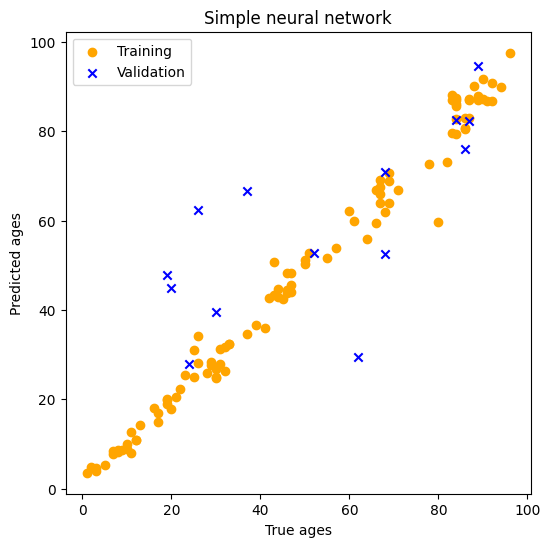

In [142]:
plt.figure(figsize=(6, 6))
plt.scatter(Y_train, preds_train_dnn, c='orange', marker='o', label='Training')
plt.scatter(Y_val, preds_val_dnn, c='blue', marker='x', label='Validation')
plt.xlabel('True ages')
plt.ylabel('Predicted ages')
plt.title('Simple neural network')
plt.legend()

#### Leave one out scoring 

In [5]:
data_arr, labels_arr = np.array(data), np.array(labels)

In [12]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error as mae, median_absolute_error as med, r2_score as r2
from sklearn.feature_selection import SelectKBest, f_regression
from warnings import catch_warnings, simplefilter
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

splitter = LeaveOneOut()
true_labels = []
pred_labels = []
# base_estimator = SVC(kernel='linear', C=1.0)
train_time, eval_time = 0.0, 0.0

with catch_warnings():
    simplefilter('ignore')
    for fold, (train_ind, val_ind) in enumerate(splitter.split(data_arr)):
        model_dnn = Sequential([
            Dense(units=64, activation=relu, input_shape=(1000,)),
            Dense(units=128, activation=relu),
            Dense(units=1)
        ])
        model_dnn.compile(optimizer=Adam(), loss=MAELoss(), metrics=[MAEMetric()])
        model = model_dnn
        X_train = data_arr[train_ind]
        X_val = data_arr[val_ind]
        Y_train = labels_arr[train_ind]
        Y_val = labels_arr[val_ind]
        feat_sel = SelectKBest(score_func=f_regression, k=1000)
        X_train_sel = feat_sel.fit_transform(X_train, Y_train)
        X_val_sel = feat_sel.transform(X_val)
        print(X_train_sel.shape, Y_train.shape, X_val_sel.shape, Y_val.shape)

        start_time = timer()
        model_dnn.fit(X_train_sel, Y_train, batch_size=1, epochs=100)
        train_time += timer() - start_time

        start_time = timer()
        pred = model.predict(X_val_sel).reshape(-1,)
        eval_time += timer() - start_time

        true_labels.append(Y_val[0])
        pred_labels.append(pred[0])

        print(f'[Fold {fold+1}/{splitter.get_n_splits(data_arr)}] ==> True label: {true_labels[-1]}, Prediction: {pred_labels[-1]}')

print(f'Average train time: {(train_time / splitter.get_n_splits(data_arr)):.6f}, Average eval time: {(eval_time / splitter.get_n_splits(data_arr)):.6f}')

132/132 [==============================] - 0s 1ms/step - loss: 6.0801 - mean_absolute_error: 6.0801
Epoch 65/100
132/132 [==============================] - 0s 3ms/step - loss: 7.0949 - mean_absolute_error: 7.0949
Epoch 66/100
132/132 [==============================] - 0s 2ms/step - loss: 6.2937 - mean_absolute_error: 6.2937
Epoch 67/100
132/132 [==============================] - 0s 1ms/step - loss: 6.6821 - mean_absolute_error: 6.6821
Epoch 68/100
132/132 [==============================] - 0s 1ms/step - loss: 6.2272 - mean_absolute_error: 6.2272
Epoch 69/100
132/132 [==============================] - 0s 2ms/step - loss: 6.9012 - mean_absolute_error: 6.9012
Epoch 70/100
132/132 [==============================] - 0s 2ms/step - loss: 5.9904 - mean_absolute_error: 5.9904
Epoch 71/100
132/132 [==============================] - 0s 2ms/step - loss: 6.0678 - mean_absolute_error: 6.0678
Epoch 72/100
132/132 [==============================] - 0s 2ms/step - loss: 5.0861 - mean_absolute_error: 5.0

In [13]:
mae_val = mae(true_labels, pred_labels)
med_val = med(true_labels, pred_labels)
r2_val = r2(true_labels, pred_labels)
print(f'MAE = {mae_val:.4f}, MED = {med_val:.4f}, R2 = {r2_val:.4f}')

MAE = 11.8575, MED = 9.8156, R2 = 0.7283


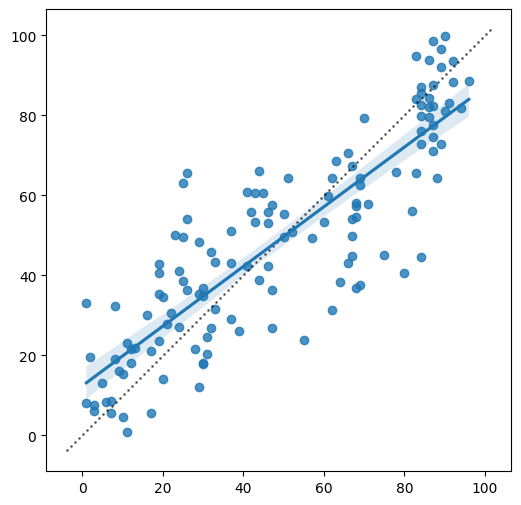

In [18]:
plt.figure(figsize=(6, 6))
regplot(x=true_labels, y=pred_labels)
xmin, xmax = plt.xlim()
plt.scatter(np.arange(xmin, xmax+1), np.arange(xmin, xmax+1), c='black', s=1, alpha=0.5)

### Hierarchical neural network

In [10]:
import numpy as np

BINS = 4

bin_endpts = np.zeros(BINS+1)
bin_endpts[BINS] = 121

Y_sorted = Y_train.sort_values(inplace=False)
for i in range(1, BINS):
    index = int(i * len(Y_sorted) / BINS)
    bin_endpts[i] = Y_sorted.iloc[index]

bin_endpts

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

In [60]:
def transform_labels(labels: pd.Series, num_bins: int, bin_endpoints: np.array) -> pd.Series:
    labels_arr = np.array(labels)
    transformed_labels_arr = np.zeros_like(labels_arr)
    for i, label in enumerate(labels_arr):
        for bin in range(num_bins):
            if label >= bin_endpoints[bin] and label < bin_endpoints[bin+1]:
                break
        transformed_labels_arr[i] = bin
    return pd.Series(transformed_labels_arr, index=labels.index)

In [73]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, MeanAbsoluteError as MAELoss
from keras.metrics import MeanAbsoluteError as MAEMetric, BinaryAccuracy

In [113]:
model_nn_bin = Sequential(layers=[
    Dense(units=64, activation=relu, input_shape=(1000,)),
    Dense(units=4)
])

models_nn_age = []
for _ in range(BINS):
    models_nn_age.append(Sequential(layers=[
        Dense(units=128, activation=relu, input_shape=(1000,)),
        Dense(units=1)
    ]))

In [114]:
model_nn_bin.compile(optimizer=Adam(), loss=BinaryCrossentropy(from_logits=True), metrics=[BinaryAccuracy()])

In [ ]:
history = model_nn_bin.fit(
    x=X_train, 
    y=pd.get_dummies(transform_labels(Y_train, BINS, bin_endpts)), 
    batch_size=1, 
    epochs=100
)

In [67]:
train_bins = []
Y_train_transformed = transform_labels(Y_train, BINS, bin_endpts)
for bin in range(BINS):
    train_bins.append((X_train[Y_train_transformed == bin], Y_train[Y_train_transformed == bin]))

In [116]:
for bin in range(BINS):
    models_nn_age[bin].compile(optimizer=Adam(), loss=MAELoss(), metrics=[MAEMetric()])
    history = models_nn_age[bin].fit(
        x=train_bins[bin][0],
        y=train_bins[bin][1],
        batch_size=1,
        epochs=250
    )

Epoch 1/250
26/26 [==============================] - 0s 1ms/step - loss: 8.6618 - mean_absolute_error: 8.6618
Epoch 2/250
26/26 [==============================] - 0s 952us/step - loss: 5.5175 - mean_absolute_error: 5.5175
Epoch 3/250
26/26 [==============================] - 0s 970us/step - loss: 5.1812 - mean_absolute_error: 5.1812
Epoch 4/250
26/26 [==============================] - 0s 1ms/step - loss: 5.0405 - mean_absolute_error: 5.0405
Epoch 5/250
26/26 [==============================] - 0s 884us/step - loss: 4.8615 - mean_absolute_error: 4.8615
Epoch 6/250
26/26 [==============================] - 0s 818us/step - loss: 4.9075 - mean_absolute_error: 4.9075
Epoch 7/250
26/26 [==============================] - 0s 882us/step - loss: 4.5819 - mean_absolute_error: 4.5819
Epoch 8/250
26/26 [==============================] - 0s 835us/step - loss: 5.0831 - mean_absolute_error: 5.0831
Epoch 9/250
26/26 [==============================] - 0s 897us/step - loss: 4.2164 - mean_absolute_error: 4.2

In [117]:
pred_bins_train, pred_bins_val = model_nn_bin.predict(X_train), model_nn_bin.predict(X_val)

1/1 [==============================] - 0s 19ms/step


In [118]:
np.argmax(pred_bins_train, axis=1), np.argmax(pred_bins_val, axis=1)
# pred_bins_train

(array([0, 0, 0, 1, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 1, 3, 1, 3, 0, 2, 0, 1,
        0, 3, 3, 0, 1, 2, 3, 0, 2, 3, 1, 3, 3, 3, 2, 3, 0, 1, 0, 2, 3, 2,
        2, 2, 0, 1, 3, 1, 2, 1, 0, 1, 2, 3, 1, 0, 0, 3, 0, 3, 0, 2, 1, 0,
        1, 0, 2, 2, 1, 3, 2, 3, 1, 2, 0, 2, 2, 2, 2, 1, 0, 3, 0, 3, 2, 1,
        2, 1, 3, 0, 2, 3, 1, 0, 0, 0, 1, 2, 2, 1, 3, 1, 2]),
 array([3, 3, 1, 3, 3, 2, 2, 1, 1, 2, 1, 2, 3, 3]))

In [119]:
eval_bins_train, eval_bins_val = [], []
pred_bin_nums_train = pd.Series(np.argmax(pred_bins_train, axis=1), index=Y_train.index)
pred_bin_nums_val = pd.Series(np.argmax(pred_bins_val, axis=1), index=Y_val.index)
for bin in range(BINS):
    eval_bins_train.append((X_train[pred_bin_nums_train == bin], Y_train[pred_bin_nums_train == bin]))
    eval_bins_val.append((X_val[pred_bin_nums_val == bin], Y_val[pred_bin_nums_val == bin]))

In [122]:
len(eval_bins_val[0][1])

0

In [124]:
preds_train_hnn, preds_val_hnn = [], []
true_train_hnn, true_val_hnn = [], []
for bin in range(BINS):
    if len(eval_bins_train[bin][1]) > 0:
        preds_train_hnn += models_nn_age[bin].predict(eval_bins_train[bin][0]).reshape(-1,).tolist()
        true_train_hnn += np.array(eval_bins_train[bin][1]).reshape(-1,).tolist()
    if len(eval_bins_val[bin][1]) > 0:
        preds_val_hnn += models_nn_age[bin].predict(eval_bins_val[bin][0]).reshape(-1,).tolist()
        true_val_hnn += np.array(eval_bins_val[bin][1]).reshape(-1,).tolist()

1/1 [==============================] - 0s 13ms/step


In [125]:
mae_train_hnn, mae_val_hnn = mae(true_train_hnn, preds_train_hnn), mae(true_val_hnn, preds_val_hnn)
med_train_hnn, med_val_hnn = med(true_train_hnn, preds_train_hnn), med(true_val_hnn, preds_val_hnn)
r2_train_hnn, r2_val_hnn = r2(true_train_hnn, preds_train_hnn), r2(true_val_hnn, preds_val_hnn)
print(f'Training: MAE = {mae_train_hnn}, MED = {med_train_hnn}, R2 = {r2_train_hnn}')
print(f'Validation: MAE = {mae_val_hnn}, MED = {med_val_hnn}, R2 = {r2_val_hnn}')

Training: MAE = 0.8510199160802931, MED = 0.7922325134277344, R2 = 0.9989144604110195
Validation: MAE = 17.732371738978795, MED = 11.42654800415039, R2 = 0.08159701505671213


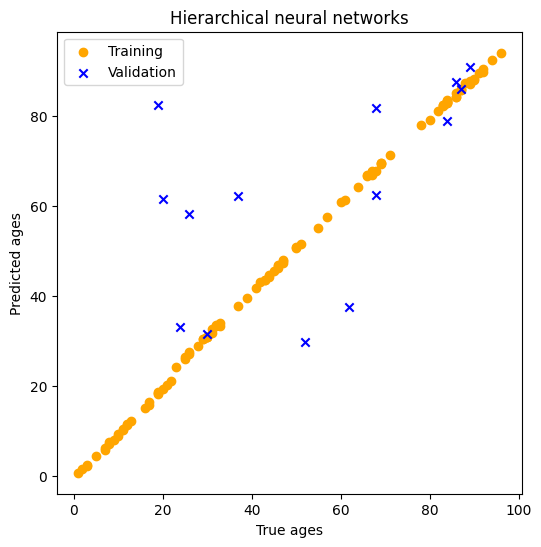

In [126]:
plt.figure(figsize=(6, 6))
plt.scatter(true_train_hnn, preds_train_hnn, c='orange', marker='o', label='Training')
plt.scatter(true_val_hnn, preds_val_hnn, c='blue', marker='x', label='Validation')
plt.xlabel('True ages')
plt.ylabel('Predicted ages')
plt.title('Hierarchical neural networks')
plt.legend()

### Hierarchical neural network (V2)

In [11]:
import torch
from torch import nn

class HierarchicalNeuralNetwork(nn.Module):
    def __init__(
        self,
        num_bins: int = BINS,
        binner_width: int = 128,
        predictor_width: int = 128
    ) -> None:
        super().__init__()
        self.binner = nn.Sequential(
            nn.Linear(in_features=1000, out_features=binner_width),
            nn.Sigmoid(),
            nn.Linear(in_features=binner_width, out_features=num_bins),
            nn.Softmax(dim=-1)
        )
        self.predictors = []
        for bin in range(num_bins):
            self.predictors.append(nn.Sequential(
                nn.Linear(in_features=1000, out_features=predictor_width),
                nn.ReLU(),
                nn.Linear(in_features=predictor_width, out_features=1)
            ))
        
    def forward(self, x, dummy=False):
        bins = self.binner(x)
        bin_preds = torch.cat([
            predictor(x) for predictor in self.predictors
        ], dim=-1)
        preds = torch.sum(bins * bin_preds, dim=-1)
        if dummy:
            print(bins.shape, bin_preds.shape, preds.shape)
        return preds


In [12]:
device = 'cpu'

In [13]:
model_hnn = HierarchicalNeuralNetwork().to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_hnn.parameters(), lr=1e-1)

In [16]:
EPOCHS=100

In [186]:
EPOCHS = 100

for epoch in range(EPOCHS):
    for i in range(len(Y_train)):
    # for i in range(1):
        optimizer.zero_grad()
        # print(torch.tensor(np.array(X_train)[i], dtype=torch.float32).reshape(1, -1).shape, torch.tensor(np.array(Y_train)[i], dtype=torch.float32).reshape(1, -1).shape)
        pred = model_hnn(torch.tensor(np.array(X_train)[i], dtype=torch.float32).reshape(1, -1))
        # print(pred.shape)
        loss = loss_fn(pred, torch.tensor(np.array(Y_train)[i], dtype=torch.float32).reshape(-1,))

        loss.backward()
        optimizer.step()
    
    with torch.inference_mode():
        # print(torch.tensor(np.array(X_train), dtype=torch.float32).shape, torch.tensor(np.array(Y_train), dtype=torch.float32).reshape(-1, 1).shape)
        preds = model_hnn(torch.tensor(np.array(X_train), dtype=torch.float32))
        # print(preds.shape)
        loss = loss_fn(preds, torch.tensor(np.array(Y_train), dtype=torch.float32).reshape(-1,))
        print(f'Epoch {epoch+1}/{EPOCHS}: MAE = {loss}')

Epoch 1/100: MAE = 48.31047821044922
Epoch 2/100: MAE = 48.30897903442383
Epoch 3/100: MAE = 48.308597564697266
Epoch 4/100: MAE = 48.30842971801758
Epoch 5/100: MAE = 48.30834197998047
Epoch 6/100: MAE = 48.30828857421875
Epoch 7/100: MAE = 48.30824661254883
Epoch 8/100: MAE = 48.30821228027344
Epoch 9/100: MAE = 48.30819320678711
Epoch 10/100: MAE = 48.30818176269531
Epoch 11/100: MAE = 48.30815505981445
Epoch 12/100: MAE = 48.30814743041992
Epoch 13/100: MAE = 48.30813980102539
Epoch 14/100: MAE = 48.30813217163086
Epoch 15/100: MAE = 48.308128356933594
Epoch 16/100: MAE = 48.30812072753906
Epoch 17/100: MAE = 48.308109283447266
Epoch 18/100: MAE = 48.308109283447266
Epoch 19/100: MAE = 48.30810546875
Epoch 20/100: MAE = 48.308101654052734
Epoch 21/100: MAE = 48.308101654052734
Epoch 22/100: MAE = 48.30809783935547
Epoch 23/100: MAE = 48.30809020996094
Epoch 24/100: MAE = 48.30809020996094
Epoch 25/100: MAE = 48.30809020996094
Epoch 26/100: MAE = 48.30808639526367
Epoch 27/100: MAE 

#### Leave one out

In [17]:
def train_fn(model_hnn, X_train, Y_train):
    for epoch in range(EPOCHS):
        for i in range(len(Y_train)):
        # for i in range(1):
            optimizer.zero_grad()
            # print(torch.tensor(np.array(X_train)[i], dtype=torch.float32).reshape(1, -1).shape, torch.tensor(np.array(Y_train)[i], dtype=torch.float32).reshape(1, -1).shape)
            pred = model_hnn(torch.tensor(np.array(X_train)[i], dtype=torch.float32).reshape(1, -1))
            # print(pred.shape)
            loss = loss_fn(pred, torch.tensor(np.array(Y_train)[i], dtype=torch.float32).reshape(-1,))

            loss.backward()
            optimizer.step()
        
        with torch.inference_mode():
            # print(torch.tensor(np.array(X_train), dtype=torch.float32).shape, torch.tensor(np.array(Y_train), dtype=torch.float32).reshape(-1, 1).shape)
            preds = model_hnn(torch.tensor(np.array(X_train), dtype=torch.float32))
            # print(preds.shape)
            loss = loss_fn(preds, torch.tensor(np.array(Y_train), dtype=torch.float32).reshape(-1,))
            print(f'Epoch {epoch+1}/{EPOCHS}: MAE = {loss}')

In [18]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error as mae, median_absolute_error as med, r2_score as r2
from sklearn.feature_selection import SelectKBest, f_regression
from warnings import catch_warnings, simplefilter
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

splitter = LeaveOneOut()
true_labels = []
pred_labels = []
# base_estimator = SVC(kernel='linear', C=1.0)
train_time, eval_time = 0.0, 0.0

with catch_warnings():
    simplefilter('ignore')
    for fold, (train_ind, val_ind) in enumerate(splitter.split(data_arr)):
        model = HierarchicalNeuralNetwork().to(device)
        X_train = data_arr[train_ind]
        X_val = data_arr[val_ind]
        Y_train = labels_arr[train_ind]
        Y_val = labels_arr[val_ind]
        feat_sel = SelectKBest(score_func=f_regression, k=1000)
        X_train_sel = feat_sel.fit_transform(X_train, Y_train)
        X_val_sel = feat_sel.transform(X_val)
        print(X_train_sel.shape, Y_train.shape, X_val_sel.shape, Y_val.shape)

        start_time = timer()
        train_fn(model, X_train, Y_train)
        train_time += timer() - start_time

        start_time = timer()
        pred = model(torch.tensor(X_val_sel, dtype=torch.float32)).reshape(-1,)
        eval_time += timer() - start_time

        true_labels.append(Y_val[0])
        pred_labels.append(pred[0])

        print(f'[Fold {fold+1}/{splitter.get_n_splits(data_arr)}] ==> True label: {true_labels[-1]}, Prediction: {pred_labels[-1]}')

print(f'Average train time: {(train_time / splitter.get_n_splits(data_arr)):.6f}, Average eval time: {(eval_time / splitter.get_n_splits(data_arr)):.6f}')

(132, 1000) (132, 1) (1, 1000) (1, 1)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x20074 and 1000x128)

In [ ]:
mae_val = mae(true_labels, pred_labels)
med_val = med(true_labels, pred_labels)
r2_val = r2(true_labels, pred_labels)
print(f'MAE = {mae_val:.4f}, MED = {med_val:.4f}, R2 = {r2_val:.4f}')

In [ ]:
plt.figure(figsize=(6, 6))
regplot(x=true_labels, y=pred_labels)
xmin, xmax = plt.xlim()
plt.scatter(np.arange(xmin, xmax+1), np.arange(xmin, xmax+1), c='black', s=1, alpha=0.5)